<a href="https://colab.research.google.com/github/pouyarb/Algorithm/blob/main/optimization_problems/IndexTracking_rev02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install yahoofinancials
!pip install PyPortfolioOpt

In [2]:
import pandas as pd
import numpy as np

from pypfopt import objective_functions, EfficientFrontier, risk_models, expected_returns, base_optimizer

import yfinance as yf
from yahoofinancials import YahooFinancials
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
# import torch
# from torch import nn

# load data

In [3]:
# list from https://www.cnbc.com/dow-30/
Dow_list = [  'AXP', 'AMGN', 'AAPL','BA','CAT','CSCO', 'CVX',
              'GS', 'HD', 'HON', 'IBM','INTC','JNJ', 'KO', 'JPM',
              'MCD','MMM', 'MRK','MSFT','NKE','PG','TRV','UNH', 'CRM',
              'VZ','V', 'WBA', 'WMT','DIS', 'DOW']
print(len(Dow_list))

30


In [4]:
yf_close_df = yf.download(Dow_list, start='2021-01-01',end='2023-09-30')['Close']

[*********************100%%**********************]  30 of 30 completed


In [5]:
from sklearn.model_selection import train_test_split

total_rows = len(yf_close_df)
train_size = int(0.8 * total_rows)

# Split the DataFrame into training and testing sets
yf_train_df = yf_close_df.iloc[:train_size]
yf_test_df = yf_close_df.iloc[train_size:]

In [ ]:
correlation_matrix = yf_close_df.corr()

# Set the size of the plot
plt.figure(figsize=(16, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set plot labels and title
plt.title("Correlation Matrix")
plt.show()

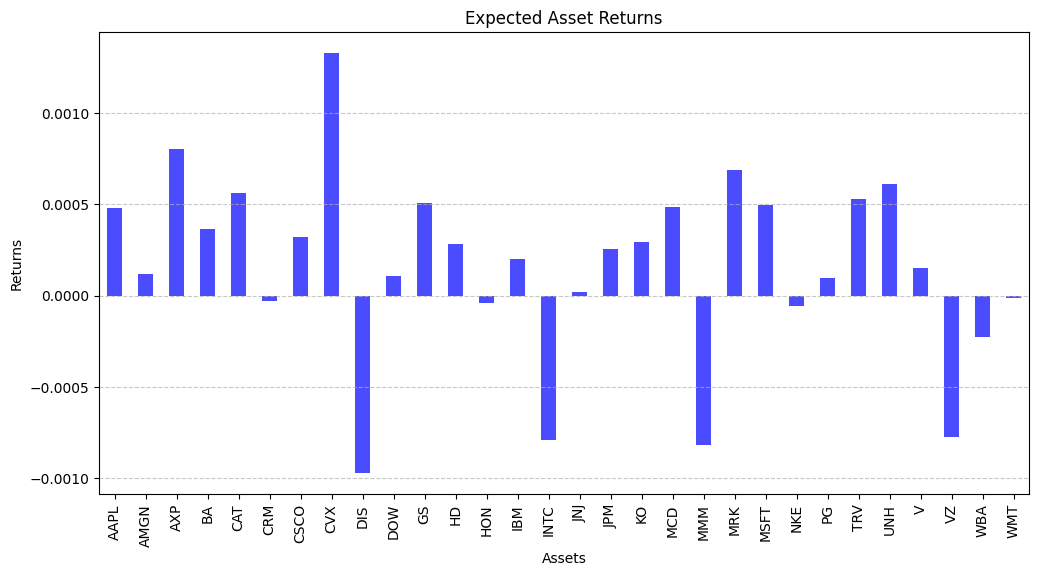

In [22]:
Sigma = yf_train_df.cov()
returns = yf_train_df.pct_change()
benchmark_return = returns.sum(axis=1).to_numpy()
historic_return = returns.to_numpy()
mu = returns.mean()

plt.figure(figsize=(12, 6))
mu.plot(kind='bar', color='blue', alpha=0.7)
plt.title('Expected Asset Returns')
plt.xlabel('Assets')
plt.ylabel('Returns')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [7]:
def plot_weights(w):
  global yf_close_df
  x_labels = yf_close_df.columns

  # Create a plot
  plt.figure(figsize=(12, 6))
  plt.plot(w)

  # Set the X-axis labels using the column names
  plt.xticks(range(len(x_labels)), x_labels, rotation=45)

  # Add labels and a title
  plt.xlabel('Assets')
  plt.ylabel('w')
  plt.title('Portfolio Weights')

  # Show the plot
  plt.show()

# scipy optimization

\begin{align*}
\text{minimize} \quad & f(w) = w^T \Sigma w \\
\text{subject to} \quad &
\begin{aligned}
&\sum_{i=1}^{n} w_i = 1 \quad \text{(Budget Constraint)} \\
&w_i \geq 0, \quad i = 1, \ldots, n \quad \text{(Non-negativity Constraint)} \\
\end{aligned}
\end{align*}

In [57]:
from scipy.optimize import minimize

def index_tracking_sci(historic, benchmark):
    n = len(mu)  # Number of assets

    def objective(w):
      x_i = w.dot(historic.T) - benchmark
      mean = np.sum(x_i) / len(benchmark)
      return np.sum(np.square(x_i - mean))

    # Constraints
    constraints = [
        {"type": "eq", "fun": lambda w: w.sum() - 1}  # Budget constraint
    ]

    bounds = [(0, 1) for _ in range(n)]  # Non-negativity constraint

    w0 = [1/n] * n  # Initial guess for weights

    result = minimize(objective, w0, bounds=bounds, constraints=constraints, method='SLSQP', options={'disp': True})

    return result

Optimization terminated successfully    (Exit mode 0)
            Current function value: 47.536502044333915
            Iterations: 6
            Function evaluations: 186
            Gradient evaluations: 6


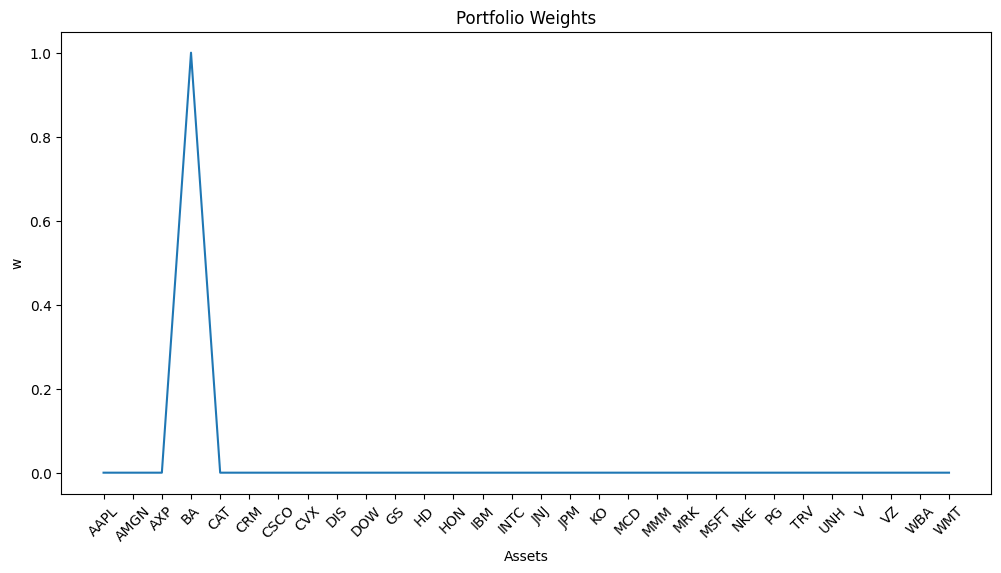

In [58]:
optim_result = index_tracking_sci(historic_return[1:], benchmark_return[1:])
w = optim_result.x
plot_weights(w)

# cvxpy optimization

In [38]:
import cvxpy as cp

def index_tracking_cvx(historic, benchmark):
    n = len(mu)  # Number of assets

    w = cp.Variable(n)

    x_i = w @ historic.T - benchmark
    mean = cp.sum(x_i) / len(benchmark)
    objective = cp.sum_squares(x_i - mean)

    # Constraints
    constraints = [
        lambda w: cp.sum(w) == 1,  # Budget constraint
        lambda w: w >= 0,
        lambda w: w <= 1
    ]

    opt = cp.Problem(cp.Minimize(objective), [f(w) for f in constraints])
    opt.solve(verbose=True)

    return opt, w

In [59]:
optim_result, w = index_tracking_cvx(historic_return[1:], benchmark_return[1:])

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Nov 10 11:28:32 AM: Your problem has 30 variables, 3 constraints, and 0 parameters.
(CVXPY) Nov 10 11:28:32 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 10 11:28:32 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Nov 10 11:28:32 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Nov 10 11:28:32 AM: Compiling problem (target solver=OSQP).
(CVXPY) Nov 10 11:28:32 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

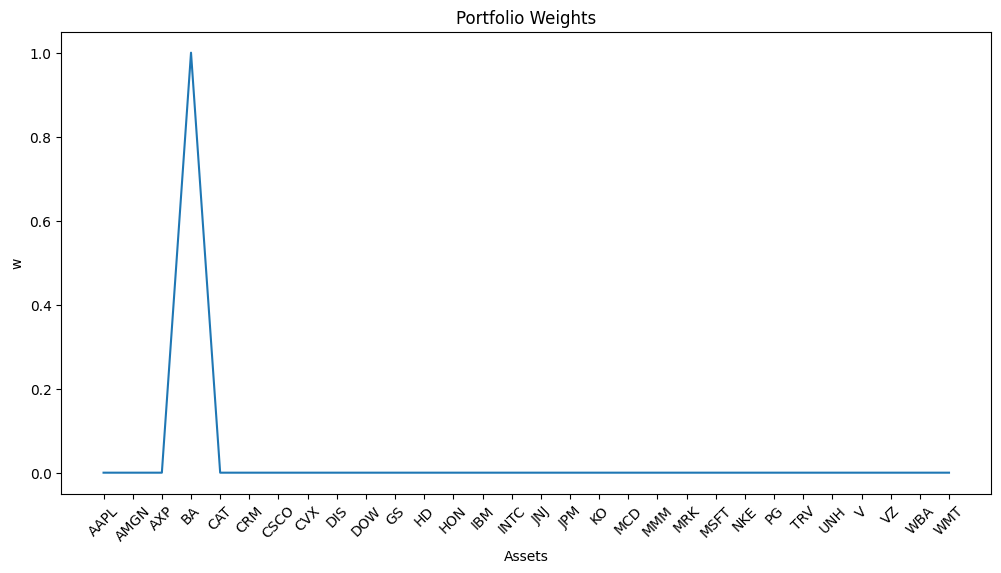

In [60]:
plot_weights(w.value)

# pypfopt optimization

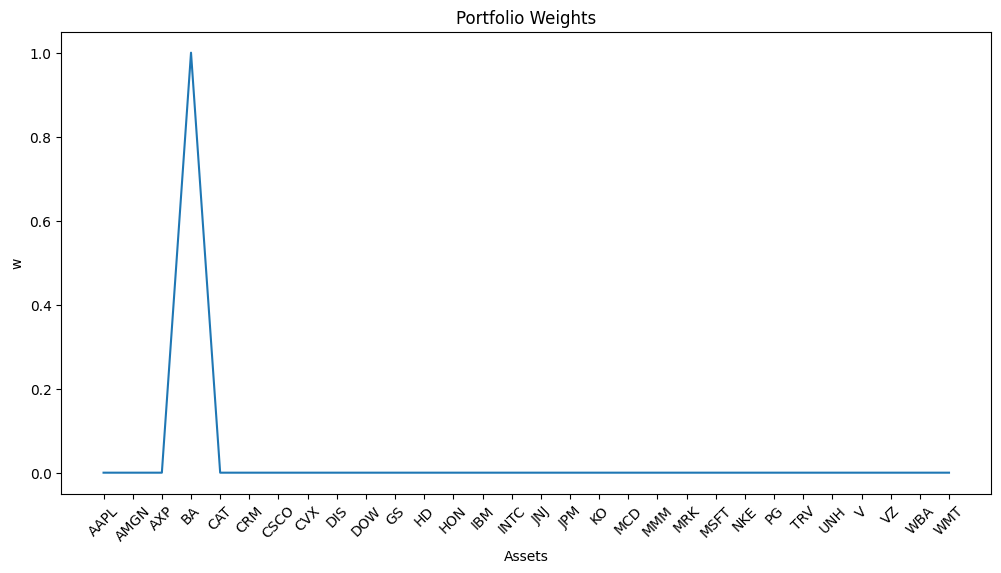

In [62]:
opt = base_optimizer.BaseConvexOptimizer(
    n_assets=len(Dow_list),
    tickers=Dow_list,
    weight_bounds=(0, 1)
)

opt.convex_objective(
    objective_functions.ex_post_tracking_error,
    historic_returns=historic_return[1:],
    benchmark_returns=benchmark_return[1:]
)

# opt.nonconvex_objective(
#     objective_functions.ex_post_tracking_error,
#     objective_args=(historic_return, benchmark_return)
# )
weights = opt.clean_weights()
plot_weights(weights.values())

# performance

In [36]:
def performance(w, mu, dist, Sigma, risk_free_rate=0):

  volatility = np.sqrt(w.dot(Sigma).dot(w))
  expected_return = w.dot(mu)
  return_a = w.dot(dist)
  sharpe = (expected_return - risk_free_rate) / volatility

  print("Expected annual return: {:.1f}%".format(100 * expected_return))
  print("annual return for 138 day: {:.1f}%".format(100 * return_a))
  print("Annual volatility: {:.1f}%".format(100 * volatility))
  print("Sharpe Ratio: {:.2f}".format(sharpe))

  return expected_return, volatility, sharpe

In [63]:
w = np.array(list(weights.values()))

returns_test = yf_test_df.pct_change()
mu_test = returns.mean()
dist = (yf_test_df.iloc[-1] / yf_test_df.iloc[0]) - 1
Sigma_test = yf_test_df.cov()

performance(w, mu_test, dist, Sigma_test)

Expected annual return: 0.0%
annual return for 138 day: -3.3%
Annual volatility: 1155.7%
Sharpe Ratio: 0.00


(0.00036692052617574926, 11.556664904709875, 3.174968982843936e-05)